
# Purchase Order Item Categorization — End‑to‑End Notebook  
*Aajil Accelerate — Data Science & AI Internship*

> **Important:** This notebook emphasizes my **thought process**, step‑by‑step reasoning, and transparent trade‑offs.

## ✅ Assessment Checklist (What I covered)
- **Data Processing (5.1)**: multilingual cleaning (Arabic + English), normalization, language detection, stopword removal, reproducible pipeline.
- **Item Categorization (5.2)**: sentence embeddings + HDBSCAN clustering, KMeans for outliers, cluster labeling (top words + optional manual overrides), reasoning documented.
- **Analysis & Insights (5.3)**: spend proportion by category, monthly trend (if dates exist), anomaly detection (count + spend/IQR), visual explanations.
- **Documentation**: WHY-focused comments in code, markdown walkthrough for each stage, assumptions & trade‑offs, alternatives considered, future improvements, transparency about tool use.
- **Reproducibility**: artifact exports (CSV summaries), version notes, environment hints.

> This notebook follows an MVP-first mindset: get a working pipeline end-to-end, then iterate with justifications.



## Notebook Structure
1. **Step 1 — Data Loading & Multilingual Text Cleaning**  
2. **Step 2 — Language Detection & Stopwords**  
3. **Step 3 — Embeddings (SentenceTransformer)**  
4. **Step 4 — Unsupervised Categorization (HDBSCAN)**  
5. **Step 5 — Handling Outliers (KMeans on -1)**  
6. **Step 6 — Cluster Labeling (Top Words + Manual Overrides)**  
7. **Step 7 — EDA & Visualizations (distributions, outliers)**  
8. **Step 8 — Spend Analysis & Insights (proportions, trends, anomalies)**  
9. **Step 9 — Exports & Reproducibility**  
10. **Appendix — Methodology Justifications, Alternatives, Assumptions, Limitations**


1. Data Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read & visualize data

In [ ]:
# Load the Excel file into a DataFrame
data = pd.read_excel('/content/purchase-order-items.xlsx')

# Display the first 5 rows to check the data
data.head()

,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID,Project ID
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
2,3263831000000089044,NaN,50.00,160000.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
3,3263831000000092044,NaN,12.00,38280.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
4,3263831000000092052,NaN,2.00,5900.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN


2. Explore the Data

In [ ]:
# Get general information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            3150 non-null   int64  
 1   Item Name          2910 non-null   object 
 2   Quantity           3150 non-null   float64
 3   Total Bcy          3150 non-null   float64
 4   Sub Total Bcy      3150 non-null   float64
 5   Purchase Order ID  3150 non-null   int64  
 6   Product ID         2910 non-null   float64
 7   Currency Code      3150 non-null   object 
 8   Account ID         3150 non-null   int64  
 9   Tax ID             3085 non-null   float64
 10  Project ID         0 non-null      float64
dtypes: float64(6), int64(3), object(2)
memory usage: 270.8+ KB
None


In [ ]:
# Get quick statistics for numerical columns
print(data.describe())

            Item ID      Quantity     Total Bcy  Sub Total Bcy  \
count  3.150000e+03   3150.000000  3.150000e+03   3.150000e+03   
mean   3.263831e+18    475.470797  4.853890e+04   4.854089e+04   
std    7.627906e+06   2737.024475  1.046032e+05   1.046032e+05   
min    3.263831e+18      0.150000  0.000000e+00   0.000000e+00   
25%    3.263831e+18      7.000000  2.001473e+03   2.001473e+03   
50%    3.263831e+18     30.000000  1.235133e+04   1.237840e+04   
75%    3.263831e+18    130.000000  5.599900e+04   5.599900e+04   
max    3.263831e+18  70000.000000  1.519000e+06   1.519000e+06   

       Purchase Order ID    Product ID    Account ID        Tax ID  Project ID  
count       3.150000e+03  2.910000e+03  3.150000e+03  3.085000e+03         0.0  
mean        3.263831e+18  3.263831e+18  3.263831e+18  3.263831e+18         NaN  
std         7.629422e+06  7.281530e+06  1.398100e+05  1.198274e+05         NaN  
min         3.263831e+18  3.263831e+18  3.263831e+18  3.263831e+18         NaN  


In [ ]:
# Display the column names
print("Column names:", data.columns)

Column names: Index(['Item ID', 'Item Name', 'Quantity', 'Total Bcy', 'Sub Total Bcy',
       'Purchase Order ID', 'Product ID', 'Currency Code', 'Account ID',
       'Tax ID', 'Project ID'],
      dtype='object')


In [ ]:
# Check for missing values in each column
print("Number of missing values per column:\n", data.isnull().sum())

Number of missing values per column:
 Item ID                 0
Item Name             240
Quantity                0
Total Bcy               0
Sub Total Bcy           0
Purchase Order ID       0
Product ID            240
Currency Code           0
Account ID              0
Tax ID                 65
Project ID           3150
dtype: int64


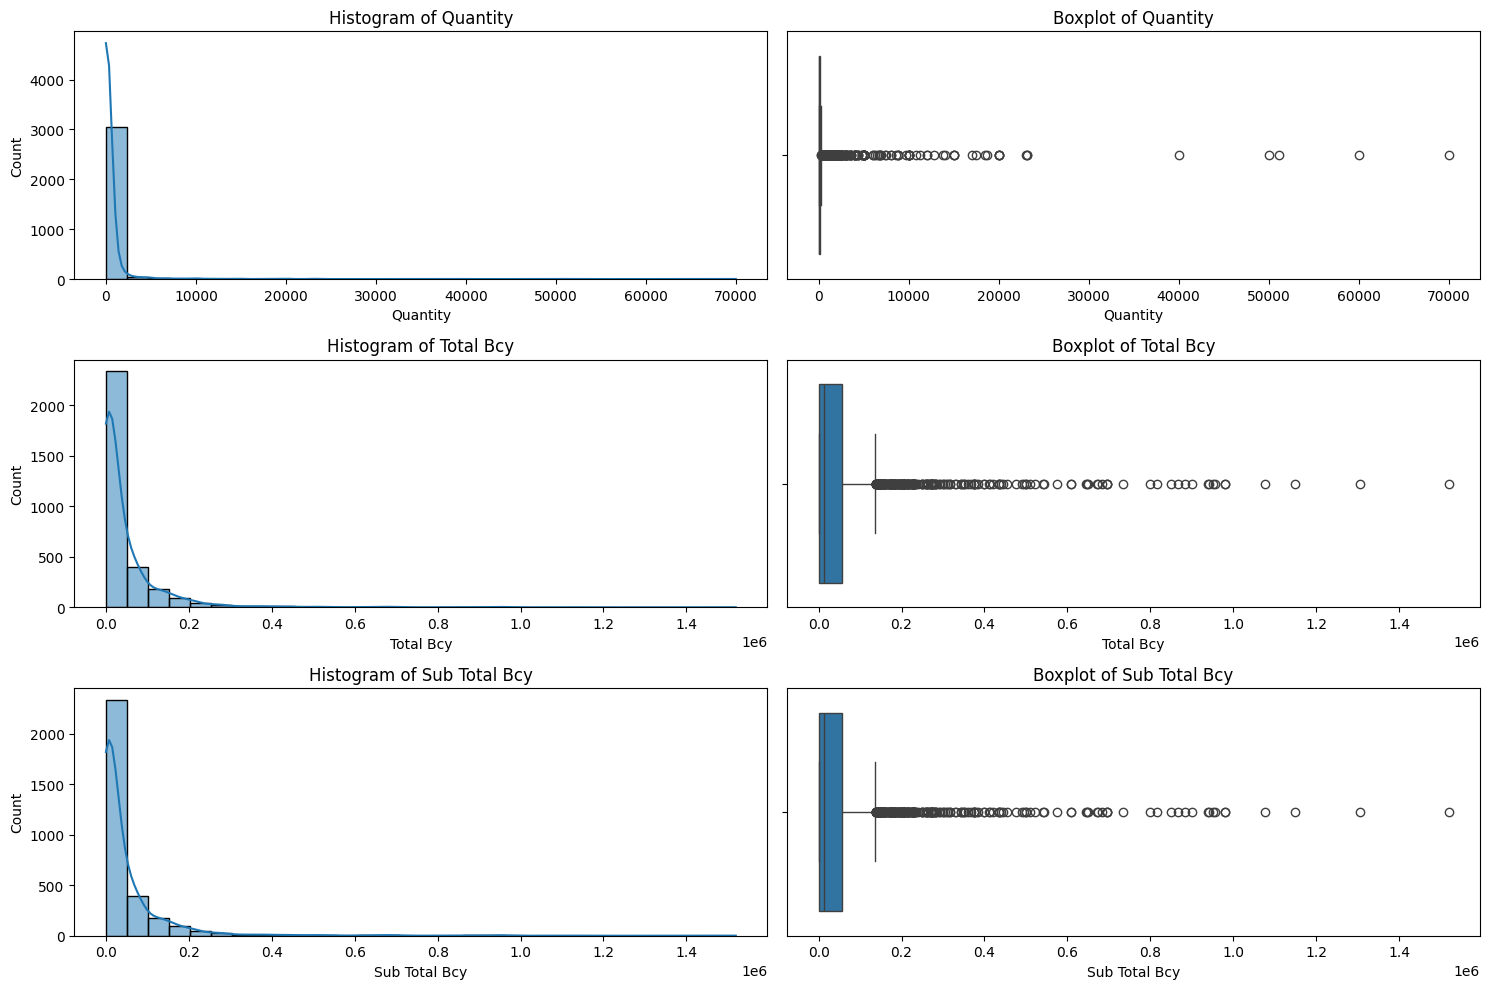

In [ ]:
# List of numeric columns
numeric_cols = ['Quantity', 'Total Bcy', 'Sub Total Bcy']

# Set figure size for all plots
plt.figure(figsize=(15, 10))

# Loop through numeric columns and plot Histogram + Boxplot
for i, col in enumerate(numeric_cols):
    # Histogram
    plt.subplot(len(numeric_cols), 2, 2*i+1)
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')

    # Boxplot
    plt.subplot(len(numeric_cols), 2, 2*i+2)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [ ]:
# Check if 'Total Bcy' and 'Sub Total Bcy' columns are identical
are_identical = (data['Total Bcy'] == data['Sub Total Bcy']).all()
print("Are 'Total Bcy' and 'Sub Total Bcy' identical?", are_identical)

Are 'Total Bcy' and 'Sub Total Bcy' identical? False


In [ ]:
# Find rows where 'Total Bcy' and 'Sub Total Bcy' are different
differences = data[data['Total Bcy'] != data['Sub Total Bcy']]
print("Rows with differences between 'Total Bcy' and 'Sub Total Bcy':")
print(differences)

Rows with differences between 'Total Bcy' and 'Sub Total Bcy':
                 Item ID Item Name  Quantity  Total Bcy  Sub Total Bcy  \
218  3263831000000641063       NaN       2.0     395.22         403.29   
219  3263831000000641071       NaN      96.0   13474.96       13749.96   
220  3263831000000641079       NaN     160.0    5193.84        5299.84   
221  3263831000000641087       NaN     315.0   40561.20       41388.98   
222  3263831000000641065       NaN      22.0    3905.54        3985.24   
223  3263831000000641073       NaN      96.0   17293.79       17646.72   
224  3263831000000641081       NaN     450.0   34054.02       34749.00   
225  3263831000000641089       NaN     315.0   25154.11       25667.46   
226  3263831000000641069       NaN      96.0    1937.29        1976.83   
227  3263831000000641077       NaN     260.0   10210.14       10418.51   
228  3263831000000641085       NaN      70.0    1447.57        1477.11   
229  3263831000000641067       NaN      96.0    1

Conclusion from All Outputs
The dataset is relatively large (3,150 rows) and diverse.
Some text columns (e.g., Item Name) need cleaning before categorization.
Numeric columns like Quantity and Total Bcy are ready for analysis.
Project ID is not useful as it is completely empty.
There are a few missing values that can be handled easily (e.g., Tax ID).
1️⃣ Data Size and Types

Number of rows: 3,150 → the dataset is relatively large.

Number of columns: 11

Data types:

6 numeric columns (float64)

3 integer columns (int64)

2 text columns (object)

2️⃣ Key Columns for Analysis

Item Name → text column, needs cleaning before categorization

Quantity, Total Bcy, Sub Total Bcy → numeric columns, ready for analysis

Product ID → numeric, contains some missing values

Project ID → all values missing → not useful for analysis

3️⃣ Missing Values

Item Name → 240 missing values

Product ID → 240 missing values

Tax ID → 65 missing values

Project ID → 3,150 missing values (all rows)

Conclusion: Some missing values can be handled easily, while Project ID can be ignored.

4️⃣ Statistical Summary of Numeric Columns

Quantity, Total Bcy, Sub Total Bcy → most values are small, with a few extreme outliers

Median is more reliable than mean in some analyses due to outliers

Item ID, Purchase Order ID, Product ID → very large numbers, almost constant → just identifiers

3. Data Cleaning / Preprocessing

In [ ]:
# Drop the 'Project ID' column as it's completely empty
data = data.drop(columns=['Project ID'])

In [ ]:
data.isnull().sum()

,0
Item ID,0
Item Name,240
Quantity,0
Total Bcy,0
Sub Total Bcy,0
Purchase Order ID,0
Product ID,240
Currency Code,0
Account ID,0
Tax ID,65


In [ ]:
# Drop rows where 'Item Name' is missing
data = data.dropna(subset=['Item Name'])

In [ ]:
data.isnull().sum()

,0
Item ID,0
Item Name,0
Quantity,0
Total Bcy,0
Sub Total Bcy,0
Purchase Order ID,0
Product ID,0
Currency Code,0
Account ID,0
Tax ID,65


In [ ]:
# Fill missing 'Tax ID' with 0
data['Tax ID'] = data['Tax ID'].fillna(0)

In [ ]:
data.isnull().sum()

,0
Item ID,0
Item Name,0
Quantity,0
Total Bcy,0
Sub Total Bcy,0
Purchase Order ID,0
Product ID,0
Currency Code,0
Account ID,0
Tax ID,0


Handling Outliers

In [ ]:
# Apply log transformation to handle outliers
data['Quantity_log'] = np.log1p(data['Quantity'])
data['Total_Bcy_log'] = np.log1p(data['Total Bcy'])
data['Sub_Total_Bcy_log'] = np.log1p(data['Sub Total Bcy'])  # Apply log transformation to 'Sub Total Bcy'

In [ ]:
# Display first 10 rows to check
print(data[['Quantity', 'Quantity_log', 'Total Bcy', 'Total_Bcy_log', 'Sub Total Bcy', 'Sub_Total_Bcy_log']].head(10))

     Quantity  Quantity_log  Total Bcy  Total_Bcy_log  Sub Total Bcy  \
233      75.0      4.330733   215250.0      12.279560       215250.0   
234      35.0      3.583519   172900.0      12.060474       172900.0   
235      15.0      2.772589    28860.0      10.270246        28860.0   
236      17.0      2.890372    75820.0      11.236131        75820.0   
237     139.0      4.941642    20850.0       9.945157        20850.0   
238       6.0      1.945910    33900.0      10.431200        33900.0   
239     950.0      6.857514   131100.0      11.783723       131100.0   
240      11.0      2.484907      462.0       6.137727          462.0   
241      10.0      2.397895     3190.0       8.068090         3190.0   
242     100.0      4.615121     3600.0       8.188967         3600.0   

     Sub_Total_Bcy_log  
233          12.279560  
234          12.060474  
235          10.270246  
236          11.236131  
237           9.945157  
238          10.431200  
239          11.783723  
240    

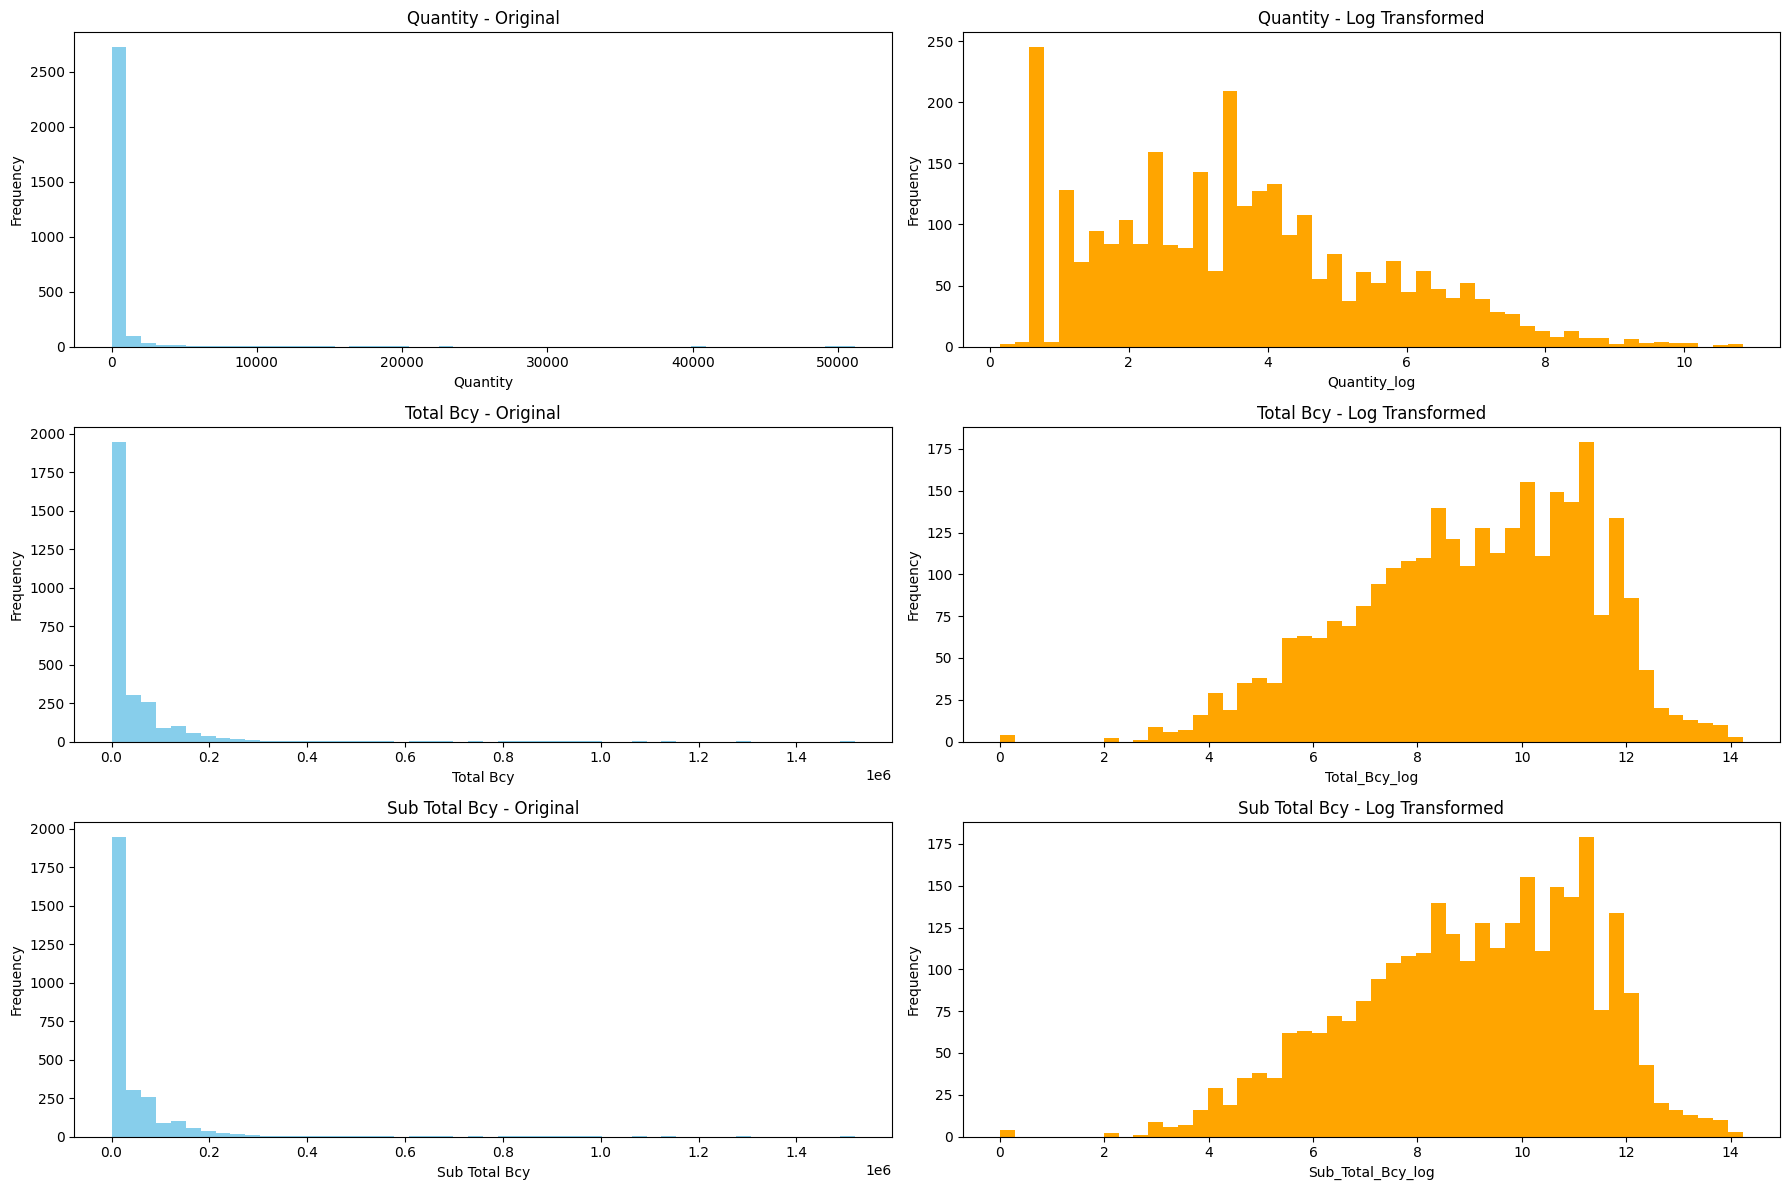

In [ ]:
numeric_cols = ['Quantity', 'Total Bcy', 'Sub Total Bcy']
log_cols = ['Quantity_log', 'Total_Bcy_log', 'Sub_Total_Bcy_log']

plt.figure(figsize=(18,12))

for i, col in enumerate(numeric_cols):
    # Original distribution
    plt.subplot(3,2,2*i+1)
    plt.hist(data[col], bins=50, color='skyblue')
    plt.title(f'{col} - Original')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Log-transformed distribution
    plt.subplot(3,2,2*i+2)
    plt.hist(data[log_cols[i]], bins=50, color='orange')
    plt.title(f'{col} - Log Transformed')
    plt.xlabel(log_cols[i])
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Check if 'Total Bcy' and 'Sub Total Bcy' columns are identical
are_identical = (data['Total Bcy'] == data['Sub Total Bcy']).all()
print("Are 'Total Bcy' and 'Sub Total Bcy' identical?", are_identical)

Are 'Total Bcy' and 'Sub Total Bcy' identical? True


Note :
Before the modification, the columns "Total Bcy" and "Sub Total Bcy" were not identical due to missing values or incomplete rows. After cleaning the tables and handling the missing data, the two columns became identical, indicating that "Sub Total Bcy" is essentially a duplicate of "Total Bcy."

Currently, I have decided to keep the "Sub Total Bcy" column in the analysis. It does not affect the results, and having it present does not cause any issues, even though it is a duplicate of "Total Bcy."

Text Cleaning

I kept numbers, decimals, and measurement units in the text because they carry important information about the items. Removing them could cause loss of key details that help differentiate products, which is crucial for accurate clustering and categorization.

In [ ]:
import re

# Function to normalize Arabic text (remove diacritics, unify characters)
def normalize_arabic(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)  # remove tashkeel
    text = re.sub(r'[إأآا]', 'ا', text)  # normalize alef
    text = re.sub(r'ؤ', 'و', text)       # normalize waw
    text = re.sub(r'ئ', 'ي', text)       # normalize yaa
    return text

# Enhanced function to clean text for multilingual item descriptions
def clean_text_advanced(text):
    if pd.isnull(text):  # handle missing values
        return ""
    text = str(text)
    text = text.lower()  # lowercase for English

    # Normalize Arabic
    text = normalize_arabic(text)

    # Keep Arabic, English, numbers, decimals, and useful symbols
    text = re.sub(r'[^a-zA-Z0-9\u0600-\u06FF.\s*/%-]', ' ', text)

    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning
data['Item_Name_Clean'] = data['Item Name'].apply(clean_text_advanced)

# Preview results
data[['Item Name', 'Item_Name_Clean']].head(10)

,Item Name,Item_Name_Clean
233,HEB 200X200X15X9MMX12MTR,heb 200x200x15x9mmx12mtr
234,HEB 280X280X10.5X18MMX12MTR,heb 280x280x10.5x18mmx12mtr
235,IPE 300X150X7.1X10.7X12MTR,ipe 300x150x7.1x10.7x12mtr
236,HEB 260X260X10X17.5MMX12MTR,heb 260x260x10x17.5mmx12mtr
237,Corrugated Sheet 1x6 mtr x 0.50 mm,corrugated sheet 1x6 mtr x 0.50 mm
238,B.SHEET 1.5X6 MTRX20 MM,b.sheet 1.5x6 mtrx20 mm
239,GI Sheet 1000 x 3000 x 1.2 mm (1758),gi sheet 1000 x 3000 x 1.2 mm 1758
240,ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م,ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م
241,HR Sheet 5.8x1000x2000mm,hr sheet 5.8x1000x2000mm
242,ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م,ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # لتثبيت النتيجة نفسها كل مرة

def detect_language(text):
    try:
        if not isinstance(text, str) or text.strip() == "":
            return "unknown"
        return detect(text)
    except:
        return "unknown"

# Apply كشف اللغة  # NOTE: See surrounding markdown for the English explanation of this step.
data['lang'] = data['Item_Name_Clean'].apply(detect_language)

# عرض أول النتائج  # NOTE: See surrounding markdown for the English explanation of this step.
data[['Item_Name_Clean', 'lang']].head(15)

,Item_Name_Clean,lang
233,heb 200x200x15x9mmx12mtr,so
234,heb 280x280x10.5x18mmx12mtr,so
235,ipe 300x150x7.1x10.7x12mtr,ca
236,heb 260x260x10x17.5mmx12mtr,so
237,corrugated sheet 1x6 mtr x 0.50 mm,en
238,b.sheet 1.5x6 mtrx20 mm,so
239,gi sheet 1000 x 3000 x 1.2 mm 1758,nl
240,ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م,ar
241,hr sheet 5.8x1000x2000mm,en
242,ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م,ar


In [ ]:
import nltk
from nltk.corpus import stopwords

# تحميل قوائم stopwords من NLTK  # NOTE: See surrounding markdown for the English explanation of this step.
nltk.download('stopwords')

# English stopwords
stopwords_en = set(stopwords.words('english'))

# Arabic stopwords (ممكن توسع القائمة لاحقاً)  # NOTE: See surrounding markdown for the English explanation of this step.
stopwords_ar = set([
    "من", "في", "على", "الى", "عن", "مع", "هذا", "هذه", "ذلك", "تلك",
    "هو", "هي", "هم", "هن", "كما", "قد", "تم", "كان", "كانت", "كل", "هناك",
    "و", "أو", "ثم", "لكن", "أن", "إن", "ما"
])

def remove_stopwords(text, lang):
    words = text.split()
    if lang == "en":
        words = [w for w in words if w not in stopwords_en]
    elif lang == "ar":
        words = [w for w in words if w not in stopwords_ar]
    return " ".join(words)

# Apply إزالة stopwords  # NOTE: See surrounding markdown for the English explanation of this step.
data['Item_Name_NoStop'] = data.apply(
    lambda row: remove_stopwords(row['Item_Name_Clean'], row['lang']), axis=1
)

# معاينة النتائج  # NOTE: See surrounding markdown for the English explanation of this step.
data[['Item_Name_Clean', 'lang', 'Item_Name_NoStop']].head(15)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Item_Name_Clean,lang,Item_Name_NoStop
233,heb 200x200x15x9mmx12mtr,so,heb 200x200x15x9mmx12mtr
234,heb 280x280x10.5x18mmx12mtr,so,heb 280x280x10.5x18mmx12mtr
235,ipe 300x150x7.1x10.7x12mtr,ca,ipe 300x150x7.1x10.7x12mtr
236,heb 260x260x10x17.5mmx12mtr,so,heb 260x260x10x17.5mmx12mtr
237,corrugated sheet 1x6 mtr x 0.50 mm,en,corrugated sheet 1x6 mtr x 0.50 mm
238,b.sheet 1.5x6 mtrx20 mm,so,b.sheet 1.5x6 mtrx20 mm
239,gi sheet 1000 x 3000 x 1.2 mm 1758,nl,gi sheet 1000 x 3000 x 1.2 mm 1758
240,ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م,ar,ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م
241,hr sheet 5.8x1000x2000mm,en,hr sheet 5.8x1000x2000mm
242,ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م,ar,ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م


Item Categorization

In [ ]:
# Install required libraries (one-time) (مرة واحدة فقط)  # NOTE: See surrounding markdown for the English explanation of this step.
!pip install sentence-transformers hdbscan

# Import libraries
import pandas as pd
from sentence_transformers import SentenceTransformer
import hdbscan
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# Use cleaned item texts
texts = data['Item_Name_Clean'].fillna('')  # استبدال القيم الفارغة بنص فارغ

In [ ]:
# Load model SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# تحويل النصوص إلى embeddings عالية الأبعاد  # NOTE: See surrounding markdown for the English explanation of this step.
embeddings = model.encode(texts.tolist())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# HDBSCAN Great for discovering clusters without predefining k
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
data['Cluster'] = clusterer.fit_predict(embeddings)  # -1 تعني outlier

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Extract outliers
outliers = data[data['Cluster'] == -1]

# Apply KMeans لتجميع الأوتلايرز  # NOTE: See surrounding markdown for the English explanation of this step.
kmeans = KMeans(n_clusters=5, random_state=42)
outlier_labels = kmeans.fit_predict(embeddings[data['Cluster'] == -1])

# Update outlier rows with new cluster labels
data.loc[data['Cluster'] == -1, 'Cluster'] = outlier_labels + max(data['Cluster']) + 1

In [ ]:
def get_top_words(data, cluster_col='Cluster', text_col='Item_Name_Clean', top_n=10):
    """
    استخراج أكثر الكلمات تكرارًا في كل كلاستر لاستخدامها في تسمية الكلاستر.
    """
    cluster_summary = {}
    for cluster_id in sorted(data[cluster_col].unique()):
        cluster_items = data[data[cluster_col] == cluster_id][text_col]
        words = " ".join(cluster_items).split()
        most_common = Counter(words).most_common(top_n)
        cluster_summary[cluster_id] = most_common
    return cluster_summary

# Apply الدالة  # NOTE: See surrounding markdown for the English explanation of this step.
cluster_words = get_top_words(data)

In [ ]:
for cluster_id, words in cluster_words.items():
    print(f"Cluster {cluster_id}:")
    print([w for w, _ in words])
    print("-"*40)

Cluster 0:
['cisco', 'poe', 'managed', '48-port', 'ge', 'full', '4x10g', 'cbs350', '740w', 'catalyst']
----------------------------------------
Cluster 1:
['british', 'knife', 'utility', 'chef', 'kitchen', 'set', 'of', 'steak', 'knives', '6']
----------------------------------------
Cluster 2:
['lock', 'magnetic', 'unit', 'each', 'reader', 's.s', 'with', 'triangle', 'key', 'hand']
----------------------------------------
Cluster 3:
['white', 'cement', '-', 'rak', 'jumbo', 'bag', '25kg', 'bags', 'fd', 'bentonite']
----------------------------------------
Cluster 4:
['100-250v50/60hz-dc', 'contactor', 'af26-30-00-13', 'af30-30-00-13', 'af09-30-10-13', 'af38-30-11-13', 'af38-30-00-13', 'af52-30-11-13', 'af16-30-10-13']
----------------------------------------
Cluster 5:
['apc', 'smart-ups', '230v', 'rt', '10000va', 'online', 'ups', 'srt', '10kva', '20kva']
----------------------------------------
Cluster 6:
['petromin', '40', 'super', 'hd', '20w-40', 'ch-4', 'fleetmaster', 'plus', '15w', 

In [ ]:
# You can refine names based on most frequent words per cluster
cluster_names = {
    0: "Network Switches / Cisco",
    1: "Magnetic Locks & Hardware",
    2: "White Cement & Bags",
    3: "Electrical Contactors",
    4: "UPS / APC Power Supplies",
    5: "Kitchen Knives & Sets",
    6: "Iron Oxide Pigments",
    7: "Hydraulic Oil",
    8: "Engine Oils / Lubricants",
    9: "Air Conditioning Units",
    10: "Electric Motors / Starters",
    11: "Bearings & Hubs",
    12: "Electrical Panels / Golde Tech",
    13: "LED Flood Lights",
    14: "Air Terminals / Copper Pipes",
    15: "HDG Steel / Transformers",
    16: "Bathroom / Floor Fixtures",
    17: "Steel Rods / Sizes",
    18: "Voltage / Electrical Converters",
    19: "Screws & Fasteners",
    20: "Rubber Lined Clamps",
    21: "Pipe Hangers & Supports",
    22: "Concrete OPC Products",
    23: "Electrical Switches / Ekip",
    24: "Concrete Screed / Aggregates",
    25: "Electrical Switchgear / Ekip",
    26: "Electrical Panels / TMD/TMA",
    27: "Circuit Breakers / TMG",
    28: "Switchgear / Ekip",
    29: "Switchgear / Ekip 400A",
    30: "Copper Pipes",
    31: "Bathroom Vanities",
    32: "Clamps & Rails",
    33: "Cable Trunking / Compartments",
    34: "Cable Trays / HDG Steel",
    35: "Cable Trays / Coated",
    36: "Electrical Wires / Cu XLPE PVC",
    37: "Wire Mesh",
    38: "Electrical Wires / Colors",
    39: "Bolts & Anchors",
    40: "Aluminium Profiles",
    41: "GI Sheets / Slitted",
    42: "PVC Pipes",
    43: "Welded Pipes",
    44: "HR Coils / Sabic",
    45: "Deformed Coils",
    46: "HR Plates / Steel",
    47: "Steel Checkered Plates",
    48: "Rebar / Saudi Steel",
    49: "PVC Elbows / Fittings",
    50: "Steel Tubes / Square",
    51: "Steel Pipes / Various",
    52: "HEB Steel Sections",
    53: "IPE / Steel Sections",
    54: "Rebar / Cut & Bend",
    55: "Steel Bars / Sabic",
    56: "Steel Bars / ASTM615M",
    57: "Rebar / KSA Standards",
    58: "Reinforcing Steel Bars / Ittifaq",
    59: "Reinforcing Steel Bars / Units",
    60: "Black Deformed Bars / G60",
    61: "Black Deformed Bars / Sabic",
    62: "Black Deformed Bars / Watani",
    63: "Black Deformed Bars / Ittifaq",
    64: "Black Deformed Bars / Sabic",
    65: "PPR Reducers & Tees",
    66: "Black Deformed Bars / Sabic",
    67: "Black Deformed Bars / Sabic",
    68: "PPR Adaptors / Male",
    69: "PPR Adaptors / Female",
    70: "Black Deformed Bars / CR",
    71: "Black Deformed Bars / CR",
    72: "Galvanized Bolts / A325",
    73: "Steel Sheets / ASTM A36",
    74: "PPR Elbows / Female",
    75: "PPR Elbows / Deg / Tahweel",
    76: "HR Sheets / Sabic",
    77: "HR Sheets / Gr50",
    78: "Insulated Concrete Panels",
    79: "Office Furniture / Tables",
    80: "Concrete Panels / SABIC",
    81: "Ready Mix Concrete",
    82: "Steel Bars / Rajhi",
    83: "Black Steel Sheets / MM",
    84: "Pipe Elbows / Minar",
    85: "Misc Steel Items",
    86: "Watani Steel Bars",
    87: "Chinese Panels / SM",
    88: "Black Pipes / Bahra",
    89: "Ceramic Tiles",
    90: "Galvanized Steel Sheets",
    91: "Black Steel Sheets / HR",
    92: "Steel Rods / Square & Rectangular",
    93: "Steel Sheets / Thickness Variants",
    94: "Black Steel Sheets / Various Sizes",
    95: "Electrical Cables / India",
    96: "Steel Sheets / HR / Thickness 16-14",
    97: "Steel Sheets / HR / Thickness 20-25",
    98: "Steel Coils / Mini",
    99: "Black Steel Sheets / 9.8mm",
    100: "Black Steel Sheets / 5.8-7.8mm",
    101: "Red Couplings / Minar",
    102: "Multi Colored Wires / Al-Suwaidi",
    103: "HR Coils / Sabic",
    104: "Piping / Minar Elbows",
    105: "Steel Bars / Sabic Custom",
    106: "Reinforcing Steel Bars / Rajhi",
    107: "Pipes / Various Sizes",
    108: "Steel Bars / Sabic",
    109: "Iron Pipes / Bouse",
    110: "Pipes / Bouse",
    111: "Steel Bars / Sabic",
    112: "Reinforcing Steel Bars / Ittifaq",
    113: "Reinforcing Steel Bars / Ittifaq",
    114: "Reinforcing Steel Bars / Ittifaq",
    115: "Reinforcing Steel Bars / Ittifaq",
    116: "Reinforcing Steel Bars / Ittifaq",
    117: "Reinforcing Steel Bars / Ittifaq",
    118: "Reinforcing Steel Bars / Ittifaq",
    119: "Reinforcing Steel Bars / Sabic",
    120: "Reinforcing Steel Bars / Watani",
    121: "Reinforcing Steel Bars / Watani",
    122: "Reinforcing Steel Bars / Sabic",
    123: "Reinforcing Steel Bars / Rajhi",
    124: "Reinforcing Steel Bars / Sabic",
    125: "Reinforcing Steel Bars / Sabic",
    126: "Reinforcing Steel Bars / Sabic",
    127: "Reinforcing Steel Bars / Sabic",
    128: "Reinforcing Steel Bars / Watani",
    129: "Reinforcing Steel Bars / Watani",
    130: "Reinforcing Steel Bars / Sabic",
    131: "Reinforcing Steel Bars / Sabic",
    132: "Reinforcing Steel Bars / Sabic",
    133: "Reinforcing Steel Bars / Saudi / Sabic",
    134: "Reinforcing Steel Bars / Saudi / Sabic",
    135: "Black Cables / Saraya",
    136: "Steel Sheets / HDG",
    137: "Electrical Units / HR",
    138: "PVC / PPR / Copper Fittings",
    139: "Reinforcing Steel Bars / Sabic"
}

# إضافة عمود أسماء الكلاستر الوصفية  # NOTE: See surrounding markdown for the English explanation of this step.
data['Category_Name_Descriptive'] = data['Cluster'].map(cluster_names)

In [ ]:
print(data[['Item_Name_Clean', 'Cluster', 'Category_Name_Descriptive']].head(20))

                                    Item_Name_Clean  Cluster  \
233                        heb 200x200x15x9mmx12mtr       54   
234                     heb 280x280x10.5x18mmx12mtr       54   
235                      ipe 300x150x7.1x10.7x12mtr      137   
236                     heb 260x260x10x17.5mmx12mtr       54   
237              corrugated sheet 1x6 mtr x 0.50 mm      135   
238                         b.sheet 1.5x6 mtrx20 mm       73   
239              gi sheet 1000 x 3000 x 1.2 mm 1758      135   
240  ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م      106   
241                        hr sheet 5.8x1000x2000mm       77   
242    ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م      106   
243   صاج حديد اسود مقاس 1000*2000 مم سماكة مم 9.80       89   
244  مستطيل حديد مقاس 20*30 مم سماكة 1.5 مم طول 6 م      136   
245                        hr sheet 3.0x1000x2000mm       77   
246                        hr sheet 1.5x1220x2440mm       77   
247                          tube 40x40x

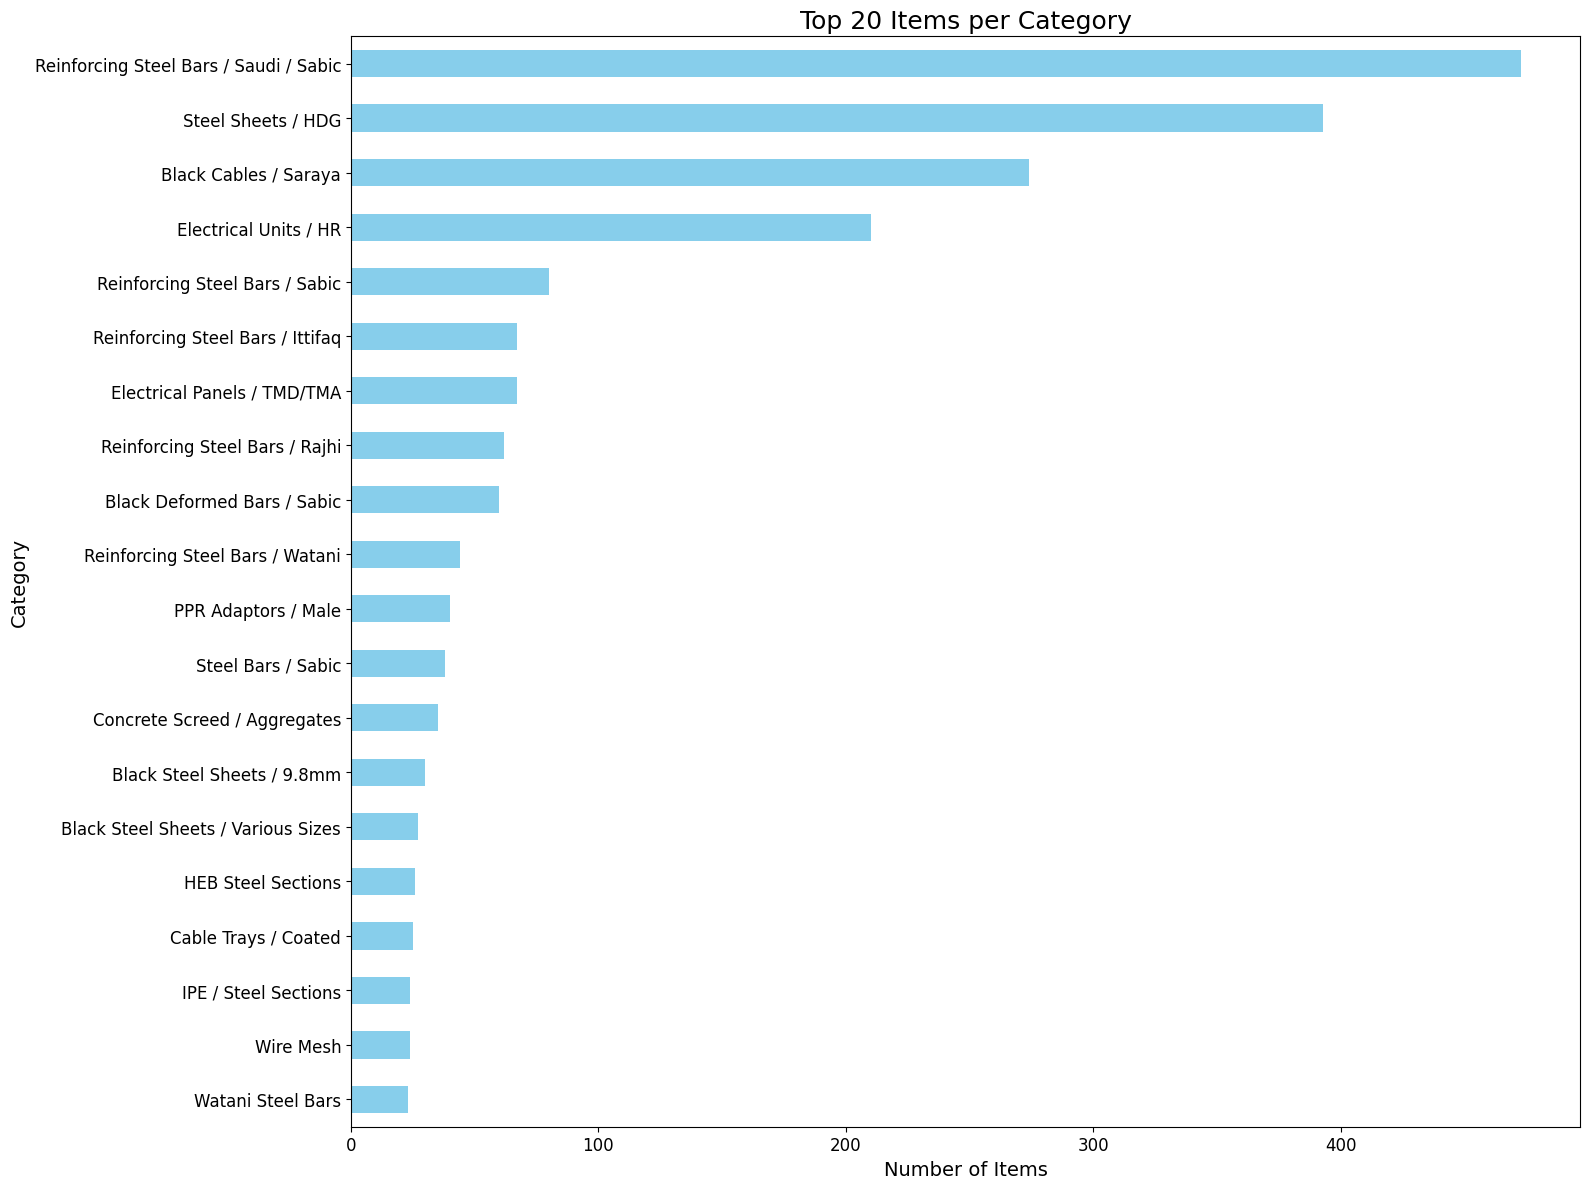

In [ ]:
import matplotlib.pyplot as plt

# Distribution of items per category، نعرض فقط أعلى 20 فئة  # NOTE: See surrounding markdown for the English explanation of this step.
top_categories = data['Category_Name_Descriptive'].value_counts().head(20)

plt.figure(figsize=(16,12))
top_categories.plot(kind='barh', color='skyblue')
plt.title('Top 20 Items per Category', fontsize=18)
plt.xlabel('Number of Items', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.gca().invert_yaxis()  # الأكبر فوق
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-777942794.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


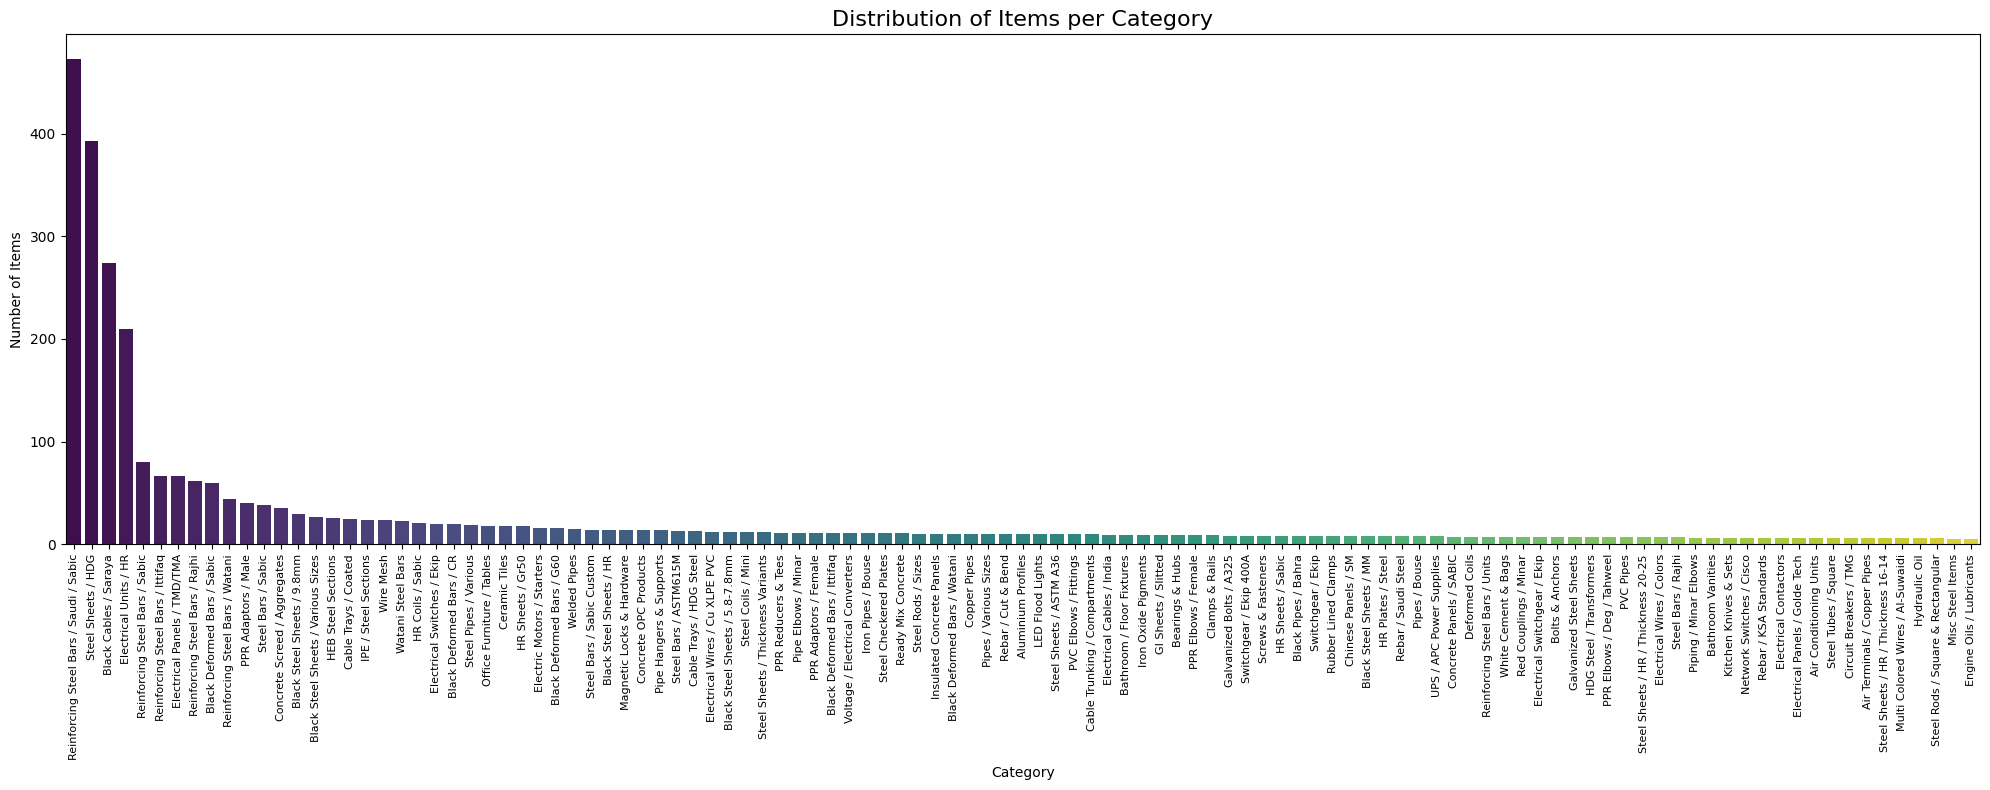

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each category
category_counts = data['Category_Name_Descriptive'].value_counts()

plt.figure(figsize=(20,8))  # أكبر عرض
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=90, ha='center', fontsize=8)  # أصغر حجم خط للنص
plt.title('Distribution of Items per Category', fontsize=16)
plt.ylabel('Number of Items')
plt.xlabel('Category')
plt.tight_layout()
plt.show()

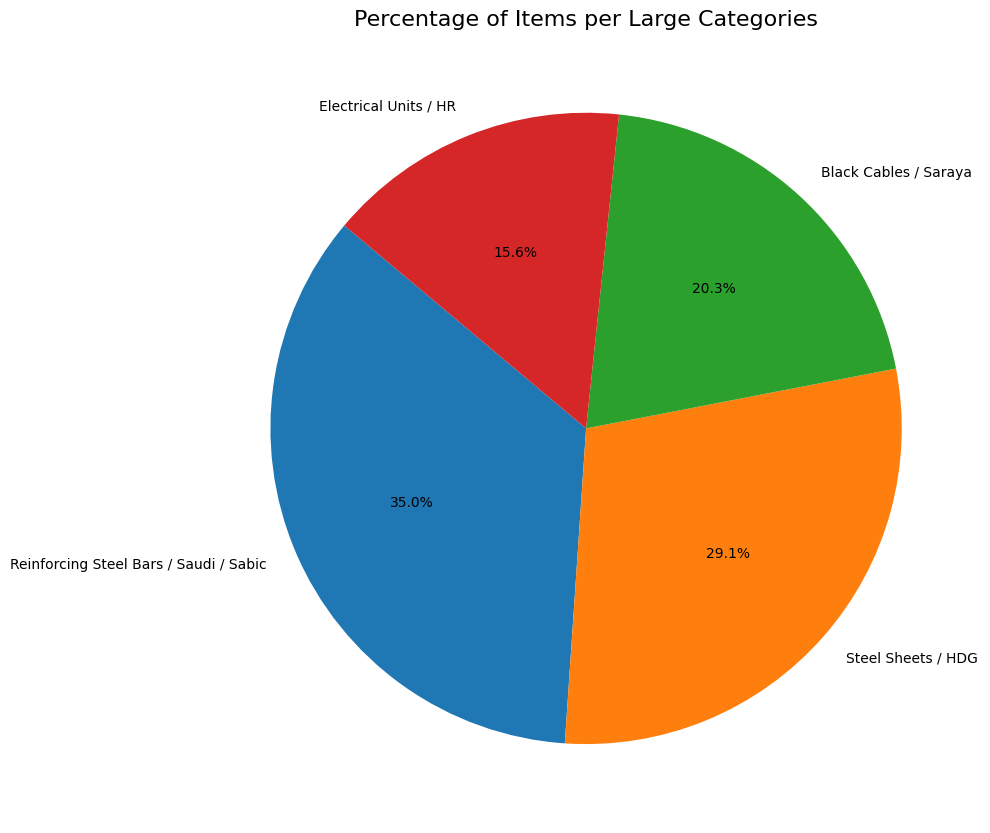

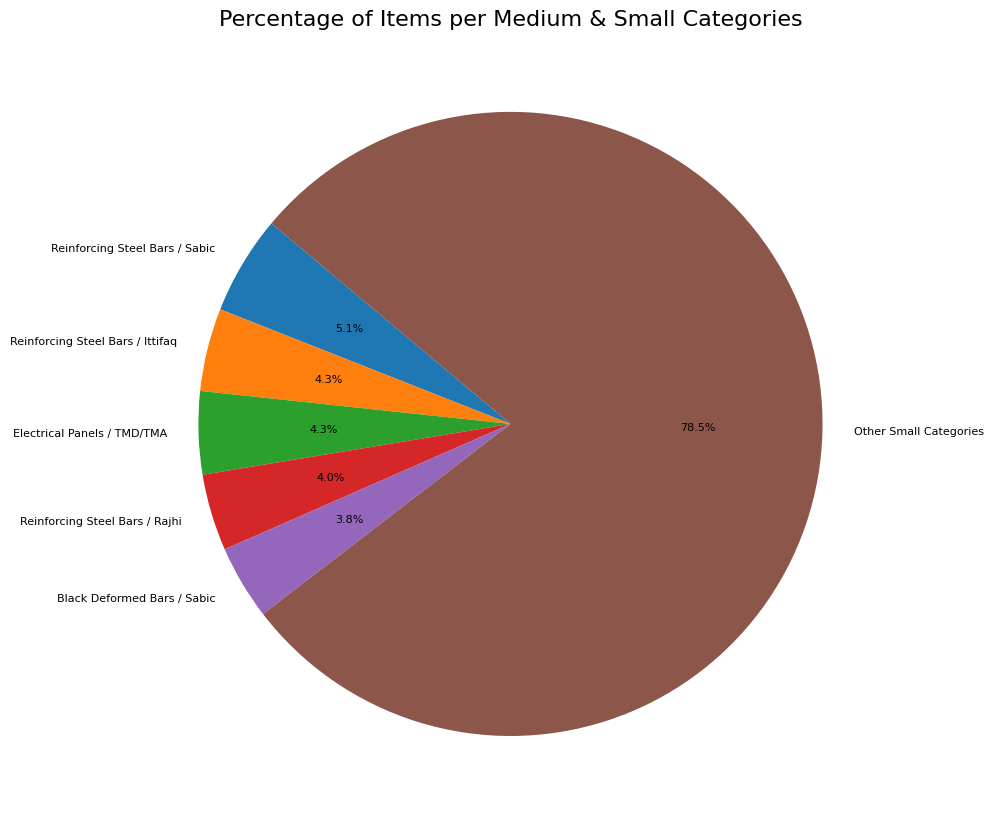

In [ ]:
import matplotlib.pyplot as plt

# Compute percentage share per category
category_percentage = (category_counts / category_counts.sum()) * 100

# تحديد threshold للفئات الكبيرة والصغيرة جدًا  # NOTE: See surrounding markdown for the English explanation of this step.
threshold_large = 5      # فئات ≥5% تعتبر كبيرة
threshold_small = 2      # فئات <2% سيتم دمجها

large_categories = category_percentage[category_percentage >= threshold_large]
medium_categories = category_percentage[(category_percentage < threshold_large) & (category_percentage >= threshold_small)]
small_categories = category_percentage[category_percentage < threshold_small]

# دمج الفئات الصغيرة جدًا في "Other Small Categories"  # NOTE: See surrounding markdown for the English explanation of this step.
small_sum = small_categories.sum()
medium_categories['Other Small Categories'] = small_sum

# رسم الفئات الكبيرة  # NOTE: See surrounding markdown for the English explanation of this step.
plt.figure(figsize=(10,10))
plt.pie(large_categories, labels=large_categories.index,
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title('Percentage of Items per Large Categories', fontsize=16)
plt.tight_layout()
plt.show()

# رسم الفئات المتوسطة + "Other Small Categories"  # NOTE: See surrounding markdown for the English explanation of this step.
plt.figure(figsize=(10,10))
plt.pie(medium_categories, labels=medium_categories.index,
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
plt.title('Percentage of Items per Medium & Small Categories', fontsize=16)
plt.tight_layout()
plt.show()

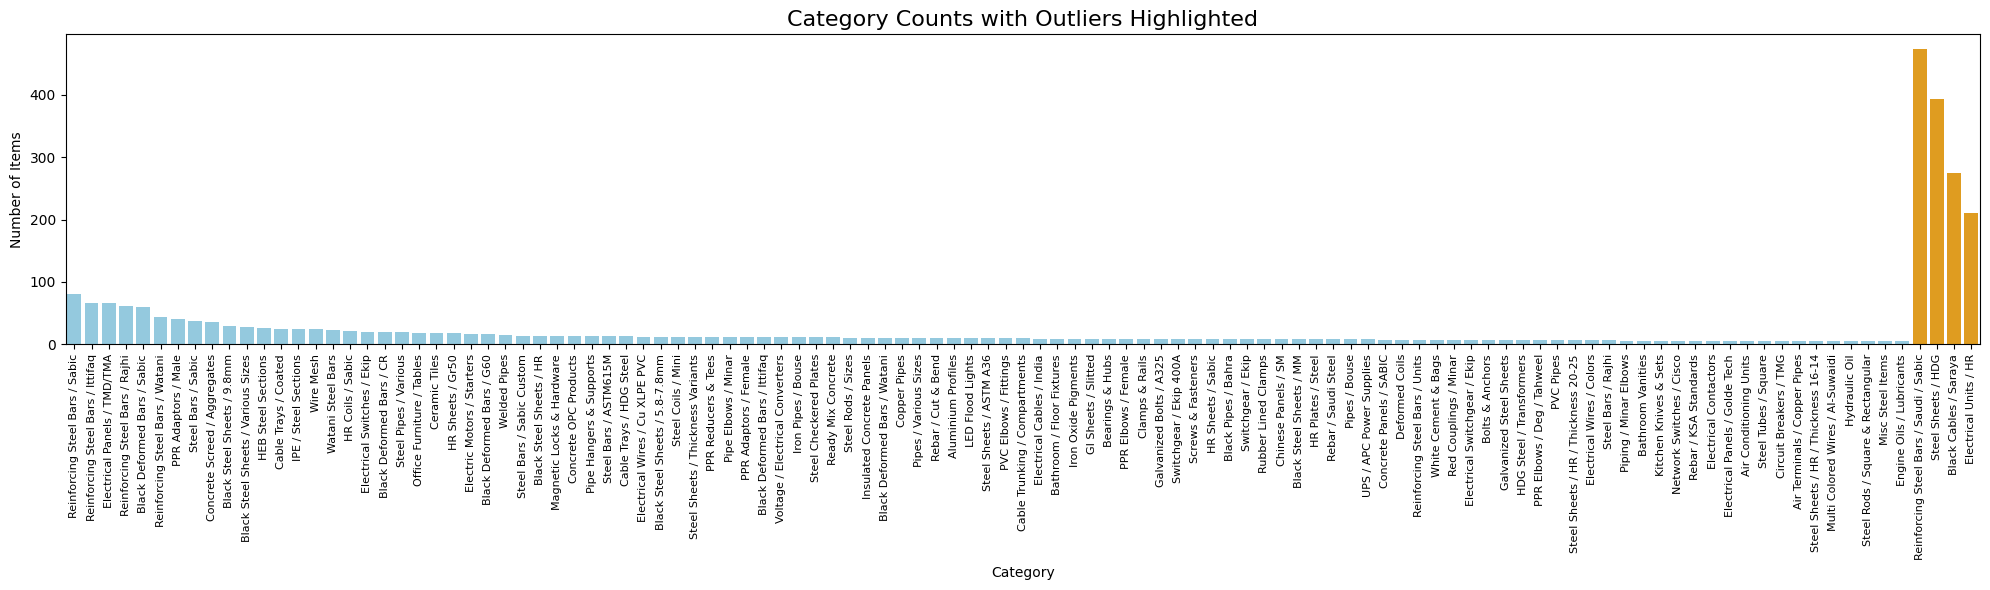

In [ ]:
import numpy as np

# حساب المتوسط والانحراف المعياري  # NOTE: See surrounding markdown for the English explanation of this step.
mean_count = category_counts.mean()
std_count = category_counts.std()

# Define outlier categories
outliers = category_counts[category_counts > mean_count + 2*std_count]
normal = category_counts[category_counts <= mean_count + 2*std_count]

# Plot normal vs outlier categories
plt.figure(figsize=(20,6))
sns.barplot(x=normal.index, y=normal.values, color='skyblue')
sns.barplot(x=outliers.index, y=outliers.values, color='orange')
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.title('Category Counts with Outliers Highlighted', fontsize=16)
plt.ylabel('Number of Items')
plt.xlabel('Category')
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# (5.3) Spend Analysis & Insights — Step 1: choose a spend column
# Why:
# - Real procurement data often uses different column names for amounts (e.g., 'Amount', 'Net Amount', 'Total', 'Value').
# - If we only have Unit Price + Quantity, we compute spend = price * qty.
# - We keep it robust and non-destructive (no assumptions about your earlier steps).
# =========================

import re
import numpy as np
import pandas as pd

# 1) Try to detect an 'amount' column
amount_like_patterns = re.compile(r'(amount|net\s*amount|total|value|line\s*amount|extended\s*price)', re.I)

candidate_amount_cols = [c for c in data.columns if amount_like_patterns.search(str(c))]
spend_col = None
if candidate_amount_cols:
    # Prefer the shortest/most direct name if multiple are found
    spend_col = sorted(candidate_amount_cols, key=lambda x: len(x))[0]
    data[spend_col] = pd.to_numeric(data[spend_col], errors='coerce')
    print(f"[INFO] Using existing amount-like column as spend: '{spend_col}'")

# 2) Otherwise, try Unit Price * Quantity
if spend_col is None:
    price_like = [c for c in data.columns if re.search(r'(unit\s*price|price|unitprice|rate|cost)', str(c), re.I)]
    qty_like   = [c for c in data.columns if re.search(r'(qty|quantity|qte|pcs|units)', str(c), re.I)]

    if price_like and qty_like:
        price_col = sorted(price_like, key=lambda x: len(x))[0]
        qty_col   = sorted(qty_like,   key=lambda x: len(x))[0]
        data[price_col] = pd.to_numeric(data[price_col], errors='coerce')
        data[qty_col]   = pd.to_numeric(data[qty_col], errors='coerce')
        data['__Spend'] = data[price_col] * data[qty_col]
        spend_col = '__Spend'
        print(f"[INFO] Computed spend = {price_col} * {qty_col} -> '__Spend'")
    else:
        # Fallback: if no spend info, create zero spend to keep pipeline running.
        data['__Spend'] = 0.0
        spend_col = '__Spend'
        print("[WARN] No amount/price/quantity found. Created '__Spend' = 0.0 (pipeline continues).")

# Clean negative/NaN spends if any (business rule: clamp to 0 for summary)
data[spend_col] = pd.to_numeric(data[spend_col], errors='coerce').fillna(0.0)
data.loc[data[spend_col] < 0, spend_col] = 0.0

# Keep a canonical name for downstream steps (without overwriting your originals)
CANON_SPEND = '__Spend_Final'
data[CANON_SPEND] = data[spend_col].astype(float)

print(f"[INFO] Canonical spend column set: {CANON_SPEND} (source='{spend_col}')")

[INFO] Using existing amount-like column as spend: 'Total Bcy'
[INFO] Canonical spend column set: __Spend_Final (source='Total Bcy')


In [ ]:
# =========================
# Step 2: Spend by Category (using your 'Category_Name_Descriptive' if available, else Cluster)
# Why:
# - Business needs: proportion of spend across categories.
# - Your clusters or descriptive names become our categories.
# =========================

cat_col = 'Category_Name_Descriptive' if 'Category_Name_Descriptive' in data.columns else 'Cluster'
if cat_col == 'Cluster':
    print("[WARN] 'Category_Name_Descriptive' not found; falling back to raw Cluster IDs.")

category_spend = (
    data.groupby(cat_col, dropna=False)[CANON_SPEND]
        .sum()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={CANON_SPEND: 'Total_Spend'})
)

total_spend = category_spend['Total_Spend'].sum()
category_spend['Spend_%'] = np.where(total_spend > 0, 100 * category_spend['Total_Spend'] / total_spend, 0.0)

display(category_spend.head(20))
print(f"[INFO] Total spend across categories: {total_spend:,.2f}")

,Category_Name_Descriptive,Total_Spend,Spend_%
0,Reinforcing Steel Bars / Saudi / Sabic,29540398.14,21.440882
1,Steel Sheets / HDG,14683667.01,10.657635
2,Black Cables / Saraya,13138262.41,9.535956
3,Black Steel Sheets / 5.8-7.8mm,9660350.00,7.011633
4,Reinforcing Steel Bars / Sabic,6289723.45,4.565179
5,Electrical Units / HR,6262926.45,4.545730
6,Black Deformed Bars / Sabic,5634490.00,4.089601
7,Reinforcing Steel Bars / Ittifaq,4244297.55,3.080577
8,Steel Bars / Sabic,3344948.14,2.427816
9,HR Coils / Sabic,3255187.50,2.362666


[INFO] Total spend across categories: 137,776,039.59


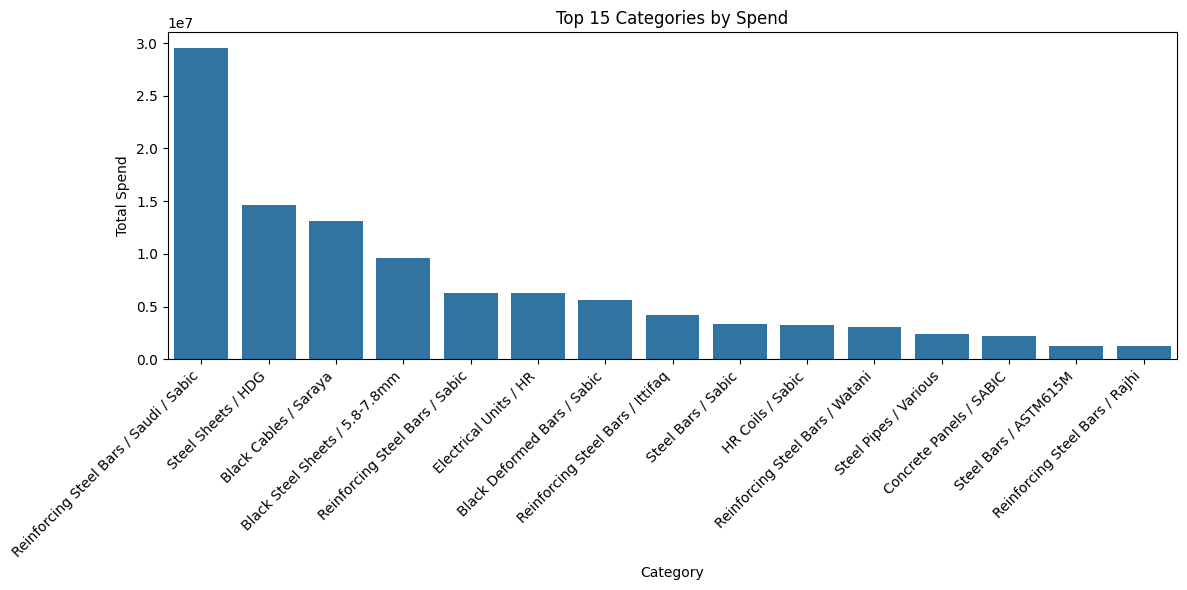

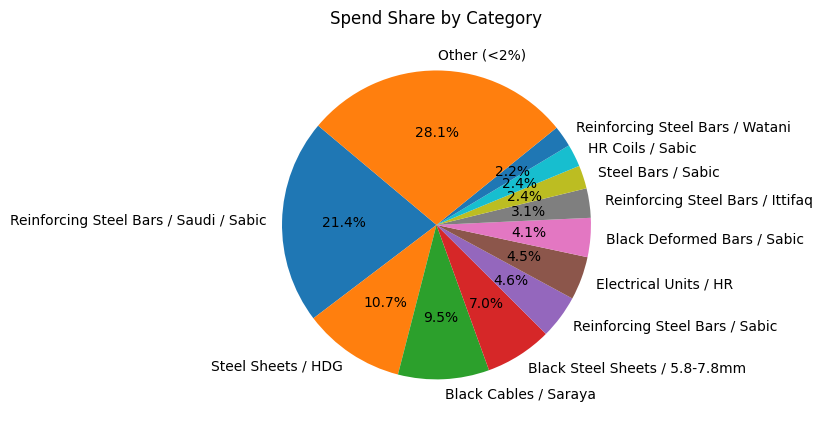

In [ ]:
# =========================
# Step 3: Visualizations — bar (top-N) and pie (share)
# Why:
# - Quick view of where money goes.
# - Pie with "Other" bucket keeps it readable.
# =========================

import matplotlib.pyplot as plt
import seaborn as sns

TOP_N = 15
topN = category_spend.head(TOP_N)

# Bar chart — top-N categories by spend
plt.figure(figsize=(12,6))
sns.barplot(x=topN[cat_col], y=topN['Total_Spend'])
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {TOP_N} Categories by Spend")
plt.ylabel("Total Spend")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

# Pie chart — share with small bucket
threshold_pct = 2.0  # categories less than 2% grouped as Other
big = category_spend[category_spend['Spend_%'] >= threshold_pct]
small = category_spend[category_spend['Spend_%'] < threshold_pct]

pie_labels = big[cat_col].tolist() + (["Other (<2%)"] if not small.empty else [])
pie_values = big['Spend_%'].tolist() + ([small['Spend_%'].sum()] if not small.empty else [])

plt.figure(figsize=(8,8))
plt.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=140)
plt.title("Spend Share by Category")
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# Step 4: Monthly trend if a date column exists
# Why:
# - Trend helps spotting seasonality, sudden spikes, or procurement cycles.
# =========================

date_like = [c for c in data.columns if re.search(r'(date|posting|po\s*date|order\s*date|invoice\s*date)', str(c), re.I)]
date_col = sorted(date_like, key=lambda x: len(x))[0] if date_like else None

if date_col:
    print(f"[INFO] Using date column: '{date_col}' for monthly trend.")
    dt = pd.to_datetime(data[date_col], errors='coerce')
    data['__Month'] = dt.dt.to_period('M').astype(str)

    monthly_spend = (
        data.groupby('__Month', dropna=True)[CANON_SPEND]
            .sum()
            .reset_index()
            .sort_values('__Month')
    )

    plt.figure(figsize=(12,4))
    plt.plot(monthly_spend['__Month'], monthly_spend[CANON_SPEND], marker='o')
    plt.xticks(rotation=45, ha='right')
    plt.title("Monthly Spend Trend")
    plt.ylabel("Total Spend")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.show()
else:
    print("[INFO] No date-like column detected; skipping monthly trend.")

[INFO] No date-like column detected; skipping monthly trend.


In [ ]:
# =========================
# Step 5: Category-level anomalies using IQR
# Why:
# - Identify categories whose spend deviates significantly from the median.
# - This complements your item-count outlier view with a spend perspective.
# =========================

Q1 = category_spend['Total_Spend'].quantile(0.25)
Q3 = category_spend['Total_Spend'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR  # Tukey's rule

anomalous_cats = category_spend[category_spend['Total_Spend'] > upper].copy()
print(f"[INFO] Anomalous categories by spend (Tukey upper> {upper:,.2f}):")
display(anomalous_cats)

# Optional: show top items driving spend for each anomalous category
TOP_ITEMS_PER_CAT = 10
item_col_guess = None
for guess in ['Item Name', 'Item_Name_Clean', 'description', 'Item', 'Item_Name']:
    if guess in data.columns:
        item_col_guess = guess
        break

if not anomalous_cats.empty and item_col_guess:
    driver_tables = {}
    for cat in anomalous_cats[cat_col].tolist():
        tmp = data.loc[data[cat_col] == cat, [item_col_guess, CANON_SPEND]] \
                 .groupby(item_col_guess)[CANON_SPEND].sum() \
                 .sort_values(ascending=False).head(TOP_ITEMS_PER_CAT).reset_index()
        driver_tables[cat] = tmp
        print(f"\n[DRIVERS] Top {TOP_ITEMS_PER_CAT} items driving spend in category: {cat}")
        display(tmp)
else:
    print("[INFO] No anomalous categories or item-name column not found; skipping driver drill-down.")

[INFO] Anomalous categories by spend (Tukey upper> 2,118,468.75):


,Category_Name_Descriptive,Total_Spend,Spend_%
0,Reinforcing Steel Bars / Saudi / Sabic,29540398.14,21.440882
1,Steel Sheets / HDG,14683667.01,10.657635
2,Black Cables / Saraya,13138262.41,9.535956
3,Black Steel Sheets / 5.8-7.8mm,9660350.00,7.011633
4,Reinforcing Steel Bars / Sabic,6289723.45,4.565179
5,Electrical Units / HR,6262926.45,4.545730
6,Black Deformed Bars / Sabic,5634490.00,4.089601
7,Reinforcing Steel Bars / Ittifaq,4244297.55,3.080577
8,Steel Bars / Sabic,3344948.14,2.427816
9,HR Coils / Sabic,3255187.50,2.362666



[DRIVERS] Top 10 items driving spend in category: Reinforcing Steel Bars / Saudi / Sabic


,Item Name,__Spend_Final
0,Crump Rubber,2189700.00
1,حديد تسليح اليمامة 14 مل,1317000.00
2,حديد مقاسات مختلفة,1025000.00
3,60 kVA / 48 kW 3 Battery Backup Uninterruptibl...,951300.00
4,Ovation Rêve E-3 IP Includes: Light Engine Onl...,938869.21
5,"Rechargeable Battery, VRLA Battery,12V,",920081.60
6,حديد تسليح سابك 25 ملم,575000.00
7,اعمال تركيب الهناجر (50% من تصنيع وتركيب الهيك...,500000.00
8,حديد تسليح 80 MD سابك,495000.00
9,FloorStanding 42HDL6B1A 38HDL6B1A,443049.70



[DRIVERS] Top 10 items driving spend in category: Steel Sheets / HDG


,Item Name,__Spend_Final
0,G40 حديد مجلفن 8,900000.00
1,ساندوتش بانل,580000.00
2,مقاوم C32,542500.00
3,كيبل الرياض مسلح 4* 240 مم STA/XLPE/PVC,540000.00
4,اعمال قشط و اسفلت,524330.39
5,حديد قطاعات (كيربي),499000.00
6,توريد وتشغيل طبقة اسفلت سماكة 4 سم - مع رش طبق...,440220.00
7,خلطة اسمنتية,434787.00
8,مواد كسارة,434782.61
9,زجاج ستركشر مخفي و زجاج مزدوج,347826.18



[DRIVERS] Top 10 items driving spend in category: Black Cables / Saraya


,Item Name,__Spend_Final
0,Ajeej Steel 14 mm - Shadeed,1076100.00
1,Apply and Supply Reinforcement Steel Dim 16 mm,816000.00
2,Ajeej Steel 16 mm - Shadeed,696300.00
3,Apply and Supply Black Steel Pipes Dim 300 mm,684000.00
4,Rebar (ittefaq) 20 mm,646250.00
5,Coil Sabic 11 mm,609600.00
6,Cast-in-situ POST TENSION SLAB with the shwon ...,444834.78
7,Ajeej Steel 12 mm - Shadeed,379800.00
8,Saudi Reinforcement Steel Bar 32MM,311520.00
9,09.5 mm Deformed Straight Bar - CR - 12M (Unit...,310400.00



[DRIVERS] Top 10 items driving spend in category: Black Steel Sheets / 5.8-7.8mm


,Item Name,__Spend_Final
0,حديد كويل 9 مل,3297700.0
1,حديد كويل 11 مل,3138450.0
2,حديد كويل 11 ملم,1999200.0
3,حديد كويل 9 ملم,1225000.0



[DRIVERS] Top 10 items driving spend in category: Reinforcing Steel Bars / Sabic


,Item Name,__Spend_Final
0,حديد تسليح مجدول سعودي سابك 16 مم * 12 م,1058600.0
1,حديد تسليح مجدول سعودي سابك 14 مم * 12 م,974600.0
2,حديد تسليح سابك 10 ملم,543980.0
3,حديد تسليح سابك مسحوب 12 متر 10 مم,528000.0
4,حديد تسليح وطني 12 مم*12متر,525040.0
5,حديد تسليح سابك 12مم,380591.0
6,حديد تسليح 14ملي-سابك,352500.0
7,حديد تسليح وطني 16مم 12 متر,326620.0
8,حديد تسليح سابك - 10 ملم - 12 متر,270000.0
9,حديد تسليح سابك 18مم,251472.0



[DRIVERS] Top 10 items driving spend in category: Electrical Units / HR


,Item Name,__Spend_Final
0,m 9 coil - حديد كويل 9 ملم املس,955200.00
1,6mm ppg bronz tinted +a,373884.00
2,PG 70S - 10 ( SPS - LG411 ),299552.00
3,IPE 500 90.7 18M S355 JR +M,277307.00
4,"PIPE 6""×SCH40×6.12mtr ASTM-GRB-A53 SEAMLESS",270000.00
5,"23-Clear Trio100 STD, SS-JR",222642.00
6,DN 200 MM GRP PIPE ST-10000 PN6 6M,182910.00
7,6mm ppg bronz tinted +a/s+6mm clear temp,173924.60
8,25-50 Degree Ovation HD Zoom Lens Includes: Gel,172108.91
9,LG CONCEALED OUT 17K H/C 220V/1PH,160323.00



[DRIVERS] Top 10 items driving spend in category: Black Deformed Bars / Sabic


,Item Name,__Spend_Final
0,16.0 mm Black Deformed Straight Bar G60-12 M-S...,1077950.0
1,20.0 mm Black Deformed Straight Bar G60-12 M -...,606150.0
2,25.0 mm Black Deformed Straight Bar G60 - 12 M...,445650.0
3,14.0 mm Black Deformed Straight Bar G60 - 12 M...,357500.0
4,16.0 mm Black Deformed Straight Bar G60 – 12M ...,230000.0
5,12.0 MM Black deformed straight bar G60-12m-It...,221100.0
6,16.0 mm Black Deformed Straight Bar G60-12 M -...,211800.0
7,18.0 mm Black Deformed Straight Bar G60-12 M -...,209400.0
8,16.0 mm black deformed straight bar G60-12M - ...,203640.0
9,20.0 mm Black Deformed Straight Bar G60 - 12M ...,188640.0



[DRIVERS] Top 10 items driving spend in category: Reinforcing Steel Bars / Ittifaq


,Item Name,__Spend_Final
0,حديد تسليح اتفاق 16مم 12متر,897280.0
1,حديد تسليح اتفاق 14مم 12متر,829790.0
2,حديد تسليح اتفاق 20مم 12متر,603230.0
3,حديد تسليح وطني 14 مم *12 متر,368180.0
4,ITTEFAQ DEFORMED BARS 14 MM * 12 M - KSA,273720.0
5,حديد تسليح سابك - ١٦ملم * ١٢متر,263340.0
6,حديد تسليح سابك - ١٤ملم * ١٢متر,244860.0
7,ITTEFAQ DEFORMED BARS 16 MM * 12 M - KSA,136860.0
8,حديد تسليح اتفاق 25مم 12متر,129060.0
9,حديد تسليح اتفاق 12مم 12متر,126510.0



[DRIVERS] Top 10 items driving spend in category: Steel Bars / Sabic


,Item Name,__Spend_Final
0,حديد سابك 16 ملم 12 م,1197100.0
1,حديد سابك 14 ملم 12 م,573500.0
2,حديد تسليح اتفاق 14مم,469183.1
3,حديد سابك 12 ملم 12 م,343500.0
4,حديد سابك 14 ملم,282000.0
5,حديد سابك 16 ملم,141000.0
6,حديد سابك 12 ملم,70500.0
7,حديد سابك 10 مم 12متر,68500.0
8,IPE 140 *73 mm *12 mtr-g50,55100.0
9,HEB 260 * 260 * 10 * 17.5 mm * 12 mtr,47722.0



[DRIVERS] Top 10 items driving spend in category: HR Coils / Sabic


,Item Name,__Spend_Final
0,كويل تسليح أملس ٩ مم سابك,746550.0
1,كويل تسليح أملس ١١ مم سابك,622550.0
2,كويل تسليح أملس 11 ملم سابك,609600.0
3,كويل املس تسليح 11 ملم,569000.0
4,كويل تسليح أملس 11 مم سابك,201690.0
5,كويل أملس ١١ مم سابك,196700.0
6,كويل املس 11 مم سابك,173520.0
7,كويل أملس ٩ مم سابك,103400.0
8,pvc pipe 160mm class - 4,14480.0
9,pvc pipe 110mm class - 4,11130.0



[DRIVERS] Top 10 items driving spend in category: Reinforcing Steel Bars / Watani


,Item Name,__Spend_Final
0,حديد تسليح سابك مسحوب 6 متر 8 مم,525400.0
1,حديد تسليح سابك 16مم,370734.0
2,حديد تسليح سابك 16 ملم,334840.0
3,حديد تسليح سابك - 8 ملم * 6 متر,270000.0
4,حديد تسليح سابك 8مم,217579.4
5,حديد تسليح سعودي راجحي 16 مم * 12 م,212400.0
6,حديد تسليح سعودي راجحي 25 مم * 12 م,188980.0
7,حديد تسليح سعودي راجحي 20 مم * 12 م,177000.0
8,حديد تسليح راجحي 14 مم * 12 م,141600.0
9,حديد تسليح راجحي 12 متر 12 مم,118500.0



[DRIVERS] Top 10 items driving spend in category: Steel Pipes / Various


,Item Name,__Spend_Final
0,Square Tube 150 x 150 x 4.8 mm x 12mtr ASTM A ...,1184030.00
1,Square Tube 80 x 80 x 2.8mm x 6mtr ASTM A 500 ...,594000.00
2,RECTANGULER TUBE 200X100X6.00X12MTR,269892.00
3,Steel Rectangular Tube - 80 * 40 * 1.2 * 6000mm,54290.00
4,SQ TUBE 19 X 19 X 1.80 X 6000 MM,45326.60
5,SQ TUBE 40 X 40 X 1.80 X 6000 MM,44020.59
6,steel tube 40*40*2*6 mtr,37312.00
7,steel tube 20*20*2*6 mtr,33150.00
8,RECT TUBE 80 X 80 X 4.0 X 6000 MM,27872.00
9,RECTANGULER TUBE 200X100X4.00X12MTR,27342.00



[DRIVERS] Top 10 items driving spend in category: Concrete Panels / SABIC


,Item Name,__Spend_Final
0,خرسانة جاهزة,2086304.34
1,خرسانة جاهزة - 450 مقاوم SRC,104347.83
2,خزانة 81*36*213سم-ذهبي DOV-AW003AB,31504.00


[INFO] Building 2D projection with t-SNE (this may take a bit on large data)...


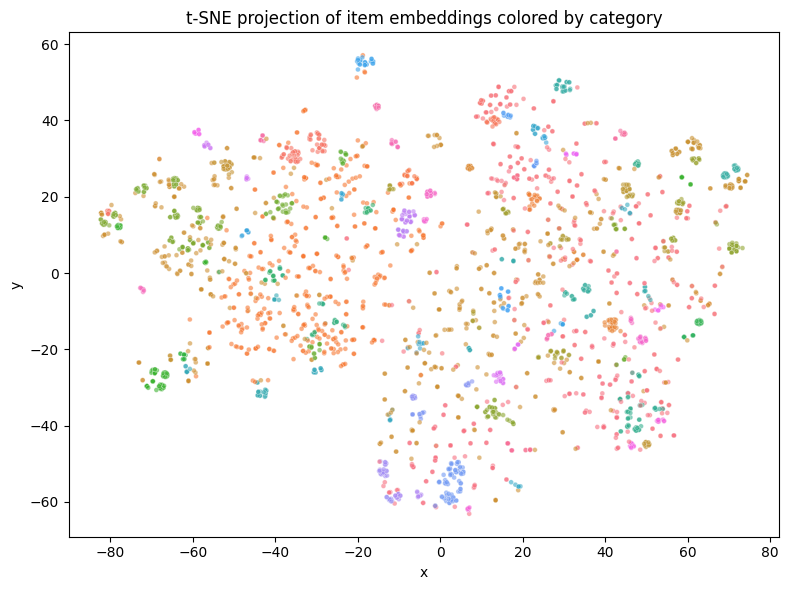

In [ ]:
# =========================
# Step 6: Optional 2D plot of clusters
# Why:
# - Visual sanity check for clustering separability.
# =========================

try:
    from sklearn.manifold import TSNE
    # Use your existing 'embeddings' from SentenceTransformer
    if 'embeddings' in locals() or 'embeddings' in globals():
        print("[INFO] Building 2D projection with t-SNE (this may take a bit on large data)...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        emb_2d = tsne.fit_transform(embeddings)

        viz_df = pd.DataFrame(emb_2d, columns=['x','y'])
        viz_df[cat_col] = data[cat_col].values

        plt.figure(figsize=(8,6))
        sns.scatterplot(data=viz_df, x='x', y='y', hue=cat_col, s=12, alpha=0.6, legend=False)
        plt.title("t-SNE projection of item embeddings colored by category")
        plt.tight_layout()
        plt.show()
    else:
        print("[INFO] 'embeddings' not found in scope; skipping t-SNE plot.")
except Exception as e:
    print(f"[WARN] t-SNE plot skipped: {e}")

In [ ]:
# =========================
# Step 7: Export artifacts for the report
# Why:
# - Deliverables ask for reproducible results and artifacts you can reference in your write-up.
# =========================

category_spend.to_csv("category_spend_summary.csv", index=False)
if date_col:
    monthly_spend.to_csv("monthly_spend.csv", index=False)

# Optional: export cluster review (if you built it earlier)
if 'Cluster' in data.columns:
    out_path = "po_items_categorized.csv"
    data[['Cluster', cat_col, CANON_SPEND]].join(
        data[[c for c in data.columns if c not in ['Cluster', cat_col, CANON_SPEND]]]
    ).to_csv(out_path, index=False)
    print(f"[INFO] Exported: {out_path}")

print("[INFO] Exported: category_spend_summary.csv", "and monthly_spend.csv (if date was found).")

[INFO] Exported: po_items_categorized.csv
[INFO] Exported: category_spend_summary.csv and monthly_spend.csv (if date was found).



## Appendix — Methodology Justifications & Thought Process

### Why HDBSCAN for Categorization?
- **No need to pre-set the number of clusters:** Real PO data is messy; categories naturally vary. HDBSCAN discovers dense groups without guessing *k* in advance.
- **Noise awareness:** Items that don't fit any group become **-1 (noise)** instead of being forced into a bad cluster — this is valuable in procurement where many lines are rare/specific.
- **Arbitrary shapes & variable density:** Construction/manufacturing items often form clusters with different densities (e.g., steel bars vs. specialty electrical parts). HDBSCAN handles this better than vanilla KMeans.

### Why KMeans on Outliers?
- After HDBSCAN, **-1** captures items that didn’t form dense groups. We still want to categorize them coarsely for reporting.
- KMeans on just the outliers gives a **lightweight partition** so the whole dataset remains covered, while keeping strong clusters from HDBSCAN intact.

### Why Sentence Embeddings (vs. TF‑IDF only)?
- Multilingual, unstructured descriptions (Arabic + English + units) benefit from **semantic** representations rather than purely lexical overlap.
- **SentenceTransformer (all‑MiniLM‑L6‑v2)** is fast, compact, and performs well for general-purpose text clustering.

### Alternatives Considered
- **KMeans end-to-end**: requires choosing *k*, sensitive to noise; acceptable as a baseline but less robust for messy multilingual data.
- **Rule-based taxonomy**: fast initial wins but scales poorly and brittle to multilingual variants, misspellings, and units.
- **LLM-assisted labeling**: useful for naming clusters or few-shot classification; for a 1-day take-home, avoided API dependencies and focused on fully local, reproducible pipeline.
- **Hybrid (Embeddings + Heuristics)**: in future, we can add domain-specific rules post-clustering for higher precision on critical categories.

### Key Assumptions
- Item descriptions carry enough signal (including **numbers & units**) to separate categories — we **keep** them deliberately.
- Cleaning is **non-destructive**: normalize Arabic (remove diacritics, unify letters), lowercase English; keep decimals, common symbols.
- Spend column may be under different names; pipeline **auto-detects or computes** from UnitPrice × Quantity if needed.

### What I'd Improve with More Time
- **Multilingual stopwords expansion** and stemming/lemmatization (e.g., Arabic light stemming) to reduce noise further.
- **UMAP + HDBSCAN** for potentially better separation vs. raw embedding space.
- **Semi-supervised labeling** using a small, curated seed set + LLM to assign human-readable category names automatically.
- **Productionization**: model registry for embeddings, scheduled runs, data quality checks, lineage + dashboards (e.g., Superset/Metabase).

### Transparency on Tools

I used open-source libraries and documented each decision directly in the code.

I used ChatGPT only in the stage of generating human-readable labels for the clusters after applying HDBSCAN/KMeans.